# Notebook 2: IV Surfaces & SVD Factors

In this notebook, we transform cleaned SPY option data into **implied volatility (IV) surfaces** and compress them using **Singular Value Decomposition (SVD)**.

We will:
- Interpolate option IVs onto a fixed grid of moneyness and maturities,
- Construct daily IV surfaces that are smooth and comparable across time,
- Apply SVD to extract 3 dominant factors (level, slope, curvature),
- Save the factor time series for downstream machine learning,
- Visualize surfaces, singular values, and factor dynamics.

This step reduces noisy, high-dimensional option data into a **small set of interpretable signals**.

## 1. Setup & Imports

We import the libraries required for this notebook:

- **pandas / numpy**: for data handling and numerical work,
- **matplotlib**: for visualization and 3D surface plots,
- **utils.py**: custom functions for building IV surfaces and running SVD.

To keep notebooks clean and reproducible, all reusable financial and mathematical logic is defined in `src/utils.py` and imported here.

In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sys.path.append(os.path.abspath(".."))
from src.utils import build_iv_surface, svd_iv_surface

## 2. Load Cleaned Data

We begin with the cleaned dataset produced in Notebook 1:

- **`options_clean.parquet`** contains:
  - standardized option quotes (mid, spread),
  - liquidity filters applied,
  - normalized variables (τ, moneyness),
  - implied volatilities,
  - Black–Scholes Greeks (Δ, Γ, Vega, Θ).

This dataset provides the reliable, analysis-ready foundation needed for surface construction.

In [2]:
df = pd.read_parquet("../data/artifacts/options_clean.parquet")
print("Shape:", df.shape)
df.head()

Shape: (1119, 21)


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,inTheMoney,contractSize,currency,type,expiry,download_date,mid,spread,tau,moneyness
0,SPY250922C00555000,2025-09-12 14:42:05+00:00,555.0,103.07,103.67,106.96,0.000000,0.000000,NaN,1.0,...,True,REGULAR,USD,C,2025-09-22,2025-09-16,105.315,0.031240,0.016438,0.895884
1,SPY250922C00560000,2025-09-10 13:37:19+00:00,560.0,93.95,98.67,101.97,0.000000,0.000000,NaN,1.0,...,True,REGULAR,USD,C,2025-09-22,2025-09-16,100.320,0.032895,0.016438,0.903955
2,SPY250922C00600000,2025-09-15 19:27:51+00:00,600.0,60.73,58.75,62.00,0.669998,1.115548,1.0,7.0,...,True,REGULAR,USD,C,2025-09-22,2025-09-16,60.375,0.053830,0.016438,0.968523
3,SPY250922C00602000,2025-09-12 19:59:34+00:00,602.0,55.90,56.71,60.00,0.000000,0.000000,NaN,1.0,...,True,REGULAR,USD,C,2025-09-22,2025-09-16,58.355,0.056379,0.016438,0.971751
4,SPY250922C00610000,2025-09-12 19:48:06+00:00,610.0,48.11,49.02,52.27,0.000000,0.000000,NaN,1.0,...,True,REGULAR,USD,C,2025-09-22,2025-09-16,50.645,0.064172,0.016438,0.984665


## 3. Define IV Surface Grid

To compare implied volatilities across days, we interpolate them onto a common grid defined by:

- **Moneyness ($K/S$):** range [0.85, 1.15] in steps of 0.02,
- **Maturities (τ):** 7, 30, 90, and 180 days, converted into years.

This grid ensures that each day’s IV surface is represented on the same scale, enabling meaningful cross-day analysis.

In [3]:
grid_moneyness = np.arange(0.85, 1.16, 0.02)
grid_taus = np.array([7, 30, 90, 180]) / 365

## 4. Build Daily IV Surfaces

For each trading day:

1. Collect all available option quotes.
2. Interpolate implied volatilities onto the fixed grid using `build_iv_surface()`.
3. Store the resulting IV surface as a matrix (τ × moneyness).

The result is a sequence of daily IV surfaces, each a consistent representation of market volatility expectations.

In [4]:
iv_matrices = []
dates = []

for date, group in df.groupby("download_date"):
    surface = build_iv_surface(group, spot=None, grid_moneyness=grid_moneyness, grid_taus=grid_taus)
    iv_matrices.append(surface)
    dates.append(date)

print(f"Built {len(iv_matrices)} IV surfaces.")


Built 3 IV surfaces.


## 5. Run SVD on IV Surfaces

We flatten each daily IV surface into a vector and stack them across time. Applying Singular Value Decomposition (SVD):

$$
M = U \Sigma V^\top
$$

- The **first mode** captures overall volatility level,
- The **second mode** captures skew (slope with respect to moneyness),
- The **third mode** captures curvature of the smile/surface.

These three modes summarize the dominant dynamics of the IV surface.

In [5]:
U, S, Vt, factors = svd_iv_surface(iv_matrices, n_modes=3)
factors["date"] = dates
factors.set_index("date", inplace=True)

# Save factors
out_path = "../data/artifacts/iv_modes.csv"
factors.to_csv(out_path)
print(f"[OK] Saved IV factors → {out_path}")
factors.head()

[OK] Saved IV factors → ../data/artifacts/iv_modes.csv


,iv_mode1,iv_mode2,iv_mode3
date,,,
2025-09-13,-1.079335,0.486358,4.157260e-16
2025-09-15,-0.891313,-0.518310,4.157260e-16
2025-09-16,1.970648,0.031952,4.157260e-16


## 6. Plots

We validate the results with three sets of visual checks:

- **3D IV surface plot:** shows the structure of the volatility smile across moneyness and maturities for a sample day,
- **Scree plot:** singular values ordered by magnitude, showing how much variance each mode explains,
- **Factor time series:** plots of iv_mode1, iv_mode2, iv_mode3 across time, showing how level, slope, and curvature evolve.

These plots confirm that our factor extraction is stable and interpretable.

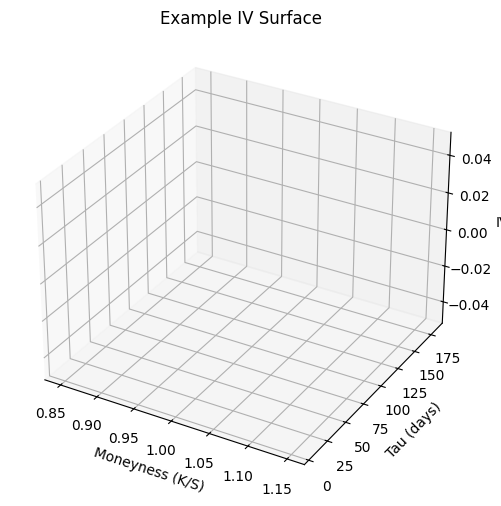

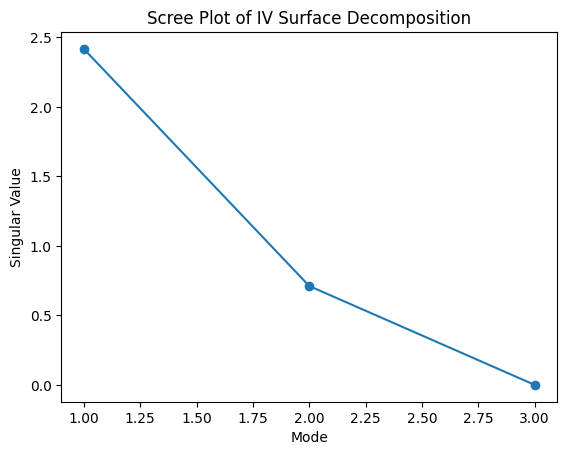

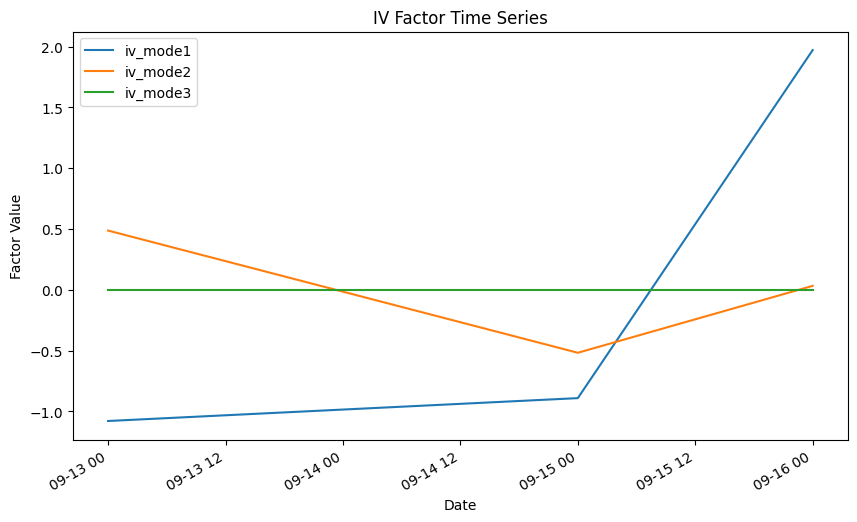

In [6]:
#(a) Example 3D IV Surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
M, T = np.meshgrid(grid_moneyness, grid_taus)
ax.plot_surface(M, T*365, iv_matrices[0], cmap="viridis")
ax.set_xlabel("Moneyness (K/S)")
ax.set_ylabel("Tau (days)")
ax.set_zlabel("IV")
ax.set_title("Example IV Surface")
plt.show()

#(b) Scree Plot of Singular Values
plt.plot(range(1, len(S)+1), S, marker="o")
plt.xlabel("Mode")
plt.ylabel("Singular Value")
plt.title("Scree Plot of IV Surface Decomposition")
plt.show()

#(c) Time Series of Factors
factors[["iv_mode1","iv_mode2","iv_mode3"]].plot(figsize=(10,6))
plt.title("IV Factor Time Series")
plt.xlabel("Date")
plt.ylabel("Factor Value")
plt.show()


# Outputs from Notebook 2

- `iv_modes.csv`: factor time series (iv_mode1, iv_mode2, iv_mode3),
- Example IV surface plots (3D visualization),
- Scree plot of singular values,
- Time series of level, slope, and curvature factors.

These outputs provide the **compact IV features** that will be used in:
- **Notebook 3:** Feature engineering and machine learning model training,
- **Notebook 4:** Backtesting the delta-hedged trading strategy.